# V-bottom Well Motility Assay and Line Scan Analysis
---

### Overview

This notebook processes and analyzes motility assays of *Chlamydomonas* strains seeded in 96- or 384-well plates with v-bottom wells, using images captured by a [Phenotype-o-mat setup](https://doi.org/10.57844/arcadia-112f-5023). The output from the Phenotype-o-mat is a single-frame AVI file (i.e. a grayscale image) of all 96 or 384 v-bottom wells. The notebook performs several key functions:

1. **GIF creation from video files**:
   - Extracts AVI video frames from Phenotype-o-mat experiments, applies time stamps, and stitches them into time-lapsed GIFs for visual inspection of motility over time.

2. **Line scan intensity analysis**:
   - Conducts horizontal line scans across the wells to quantify cell density, differentiating between non-motile cells (which sink to the bottom of the well) and motile cells (which remain suspended). Metrics such as minimum intensity, average intensity, and their differences/ratios are computed for further analysis.

3. **Visualization and statistical testing**:
   - Annotates and displays the processed well images, overlays line scan plots, and performs either Mann-Whitney U tests with Bonferroni correction or one-way ANOVA and post-hoc Tukey tests to evaluate differences between treatments across multiple strains.

Output from this notebook was used to generate figures and statistical analyses related to cell motility for the study, contributing to Figures 2 and 4 in the [publication](https://doi.org/10.57844/arcadia-fe2a-711e).

ChatGPT was used draft the scripts in this notebook.

## 1. GIF creation from video files
---

In [3]:
%run ../src/scripts/create_vbottom_gifs.py \
    --zipfolder "../data/vbottom_motility_assay/vbottom_motility_strains.zip" \
    --gif "../results/vbottom_strain_output_video.gif"

%run ../src/scripts/create_vbottom_gifs.py \
    --zipfolder "../data/vbottom_motility_assay/vbottom_motility_treatment.zip" \
    --gif "../results/vbottom_treatment_output_video.gif"

Files extracted to: ../data/vbottom_motility_assay/vbottom_motility_strains
Outputting GIF to: ../results/vbottom_strain_output_video.gif
Processing 96 files...
GIF creation complete.
Files extracted to: ../data/vbottom_motility_assay/vbottom_motility_treatment
Outputting GIF to: ../results/vbottom_treatment_output_video.gif
Processing 96 files...
GIF creation complete.


## 2. Line scan intensity analysis (Figure 2)
---
Prior to this analysis, I opened the last single-frame AVI acquired in the dataset in FIJI and cropped the image to only include the wells of interest. I then saved the image as a TIF. 

### Purpose:
This code performs line scan analyses on an image of a 384-well v-bottom plate seeded with *Chlamydomonas* strains to measure cell density and motility defects. It visualizes, compares, and exports data for statistical analysis across three strains (`CC-125`, `CC-2670`, `CC-3707`).

### Key Steps:
1. **Image Handling**

2. **Visualization**
 
3. **Data Processing**

4. **Statistical Analysis**

5. **Plotting**

### Outputs:
- **Marked Images**: PNG files with scanned lines and labels.
- **Plots**: SVG showing overlaid line scans for each strain.
- **Data Files**: CSVs with line scan intensities and statistical comparison results.

### Libraries:
- `tifffile`, `opencv`, `matplotlib`, `pandas`, `scipy.stats`, `arcadia-pycolor`.

This notebook provides a reproducible pipeline for visualizing, analyzing, and statistically comparing motility data across *Chlamydomonas* strains.

In [4]:
import os
import sys
from itertools import combinations

import arcadia_pycolor as apc
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as stats
import tifffile as tiff
from PIL import Image, ImageDraw, ImageFont
from skimage.draw import line
from statsmodels.stats.multicomp import pairwise_tukeyhsd

# Set the default matplotlib styles using arcadia-pycolor
apc.mpl.setup()

### Image Handling
   - Loads a TIFF image of a plate and identifies well centers.
   - Performs horizontal line scans through each well, aligning scans by minimum intensity (representing non-motile cells).

In [5]:
# Filepath to the TIFF file
image_path = "../data/vbottom_motility_assay/cropped_final_frames/algae_growth_curve_00000_1722972387-1_FinalFrame_Crop.tif"  # noqa: E501

# Verify that the file exists
if not os.path.exists(image_path):
    print(f"Error: File not found at path {image_path}")
    sys.exit()

# Attempt to open the image using tifffile
try:
    image = tiff.imread(image_path)
    print("Image opened successfully!")
except OSError:
    print("Error: Could not open image with tifffile.")
    sys.exit()

# Convert the image to grayscale if it's not already
if len(image.shape) > 2:
    image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

# Define the number of rows and columns in the well plate you want to analyze
num_rows = 6
num_cols = 11

# Diameter and scan width of the wells
well_diameter = 70
scan_width = 10
scan_length = 40

# Identify the centers of the wells
height, width = image.shape
row_spacing = height // num_rows
col_spacing = width // num_cols

# Calculate precise center positions of the wells
well_centers = [
    (int((row + 0.5) * row_spacing), int((col + 0.5) * col_spacing))
    for row in range(num_rows)
    for col in range(num_cols)
]

# Create a list to store the line scan results
line_scans = []

# Perform line scans, realign, and normalize data
for i, (center_y, center_x) in enumerate(well_centers):
    start_x = max(center_x - scan_length // 2, 0)
    end_x = min(center_x + scan_length // 2, width - 1)

# Perform a horizontal line scan across the center with a width of scan_width
    line_intensity = []
    for offset in range(-scan_width // 2, scan_width // 2 + 1):
        rr, cc = line(center_y + offset, start_x, center_y + offset, end_x)
        line_intensity.append(image[rr, cc])

# Ensure all scans are of the same length by trimming to scan_length
    line_intensity = [scan[:scan_length] for scan in line_intensity]
    line_intensity = np.mean(line_intensity, axis=0)

# Realign the line scan by aligning the minimum point within a broader search region
    broader_search_indices = np.arange(10, 30)
    min_index = broader_search_indices[np.argmin(line_intensity[broader_search_indices])]
    shift = (scan_length // 2) - min_index
    line_intensity = np.roll(line_intensity, shift)

# Store the realigned and normalized result
    line_scans.append(line_intensity)

Image opened successfully!


### Visualization
  - Draws scanned lines and sample labels on the image.
   - Saves and displays marked images with scan lines and detailed well information.

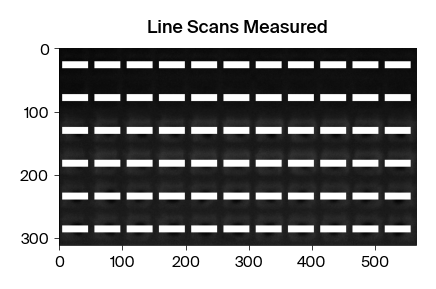

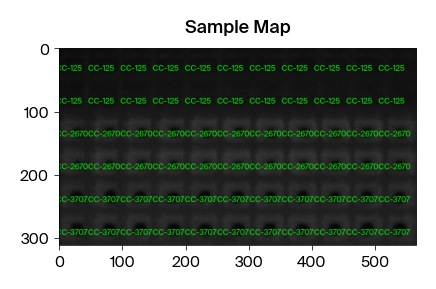

True

In [6]:
# Create a copy of the image to draw the lines on
image_with_lines = image.copy()
image_with_details = cv2.cvtColor(image.copy(), cv2.COLOR_GRAY2BGR)

# Updated labels for each well
labels = [
    ["CC-125"] * num_cols,
    ["CC-125"] * num_cols,
    ["CC-2670"] * num_cols,
    ["CC-2670"] * num_cols,
    ["CC-3707"] * num_cols,
    ["CC-3707"] * num_cols,
]

flat_labels = [label for row in labels for label in row]

# Load the Suisse Int'l font
try:
    font_path = "/path/to/SuisseIntl-Regular.ttf"
    font = ImageFont.truetype(font_path, 12)
except OSError:
    print("Suisse Int'l font not found. Using default font.")
    font = ImageFont.load_default()

# Convert the image_with_details to PIL format for text drawing
image_with_details_pil = Image.fromarray(cv2.cvtColor(image_with_details, cv2.COLOR_BGR2RGB))
draw = ImageDraw.Draw(image_with_details_pil)

# Draw lines on the image and label the wells
for i, (center_y, center_x) in enumerate(well_centers):
    start_x = max(center_x - scan_length // 2, 0)
    end_x = min(center_x + scan_length // 2, width - 1)

    for offset in range(-scan_width // 2, scan_width // 2 + 1):
        rr, cc = line(center_y + offset, start_x, center_y + offset, end_x)
        image_with_lines[rr, cc] = 255

    # Add sample details to the detailed image using PIL
    draw.text((center_x - 30, center_y), flat_labels[i], font=font, fill=(0, 255, 0))

# Convert back to OpenCV format
image_with_details = cv2.cvtColor(np.array(image_with_details_pil), cv2.COLOR_RGB2BGR)

# Display the images with the scanned lines and details
plt.imshow(image_with_lines, cmap="gray")
plt.title("Line Scans Measured")
plt.show()

plt.imshow(image_with_details)
plt.title("Sample Map")
plt.show()

# Save the images
marked_image_path = "../results/linescan_strain_results/marked_well_lines.png"
details_image_path = "../results/linescan_strain_results/marked_details.png"
os.makedirs(os.path.dirname(marked_image_path), exist_ok=True)
cv2.imwrite(marked_image_path, image_with_lines)
cv2.imwrite(details_image_path, image_with_details)

### Data Processing
   - Computes pixel intensity averages for positions 33-37, minimum intensity values, and the difference/ratio between them.
   - Exports line scan results to CSV.

In [7]:
# Define end tail of the line scan where only motile cells will be
pixel_range = range(33, 38)

# Create lists to store the values for each well
pixel_33_37_values = []
pixel_33_37_avg_list = []
min_value_list = []
difference_list = []
fraction_list = []

# Loop over each scan to calculate the statistics
for scan in line_scans:
    # Measure the intensity values of the line scan tail between pixel positions 33 and 37
    pixel_33_37 = scan[33:38]
    pixel_33_37_values.append(list(pixel_33_37))

    # Calculate the average intensity of the tail (pixels 33-37)
    pixel_33_37_avg = np.mean(pixel_33_37)
    pixel_33_37_avg_list.append(pixel_33_37_avg)

    # Identify the minimum value across the entire scan
    min_value = np.min(scan)
    min_value_list.append(min_value)

    # Subtract the minimum value from tails average (pixels 33-37)
    difference = pixel_33_37_avg - min_value
    difference_list.append(difference)

    # Divide the tails average (pixels 33-37) by the minimum value
    if min_value != 0:
        fraction = pixel_33_37_avg / min_value
    else:
        fraction = np.nan

    fraction_list.append(fraction)

# Convert to DataFrame and export
export_df = pd.DataFrame(
    {
        "Well": [f"Well {row+1}-{col+1}" for row in range(num_rows) for col in range(num_cols)],
        "Strain": flat_labels,
        "Pixel_33_37_Values": pixel_33_37_values,
        "Pixel_33_37_Avg": pixel_33_37_avg_list,
        "Min_Value": min_value_list,
        "Difference_33_37_Avg_Min": difference_list,
        "Fraction_33_37_Avg_Min": fraction_list,
    }
)

# Export the data to a CSV file
csv_path = "../results/linescan_strain_results/pixel_33_37_min_comparisons.csv"
export_df.to_csv(csv_path, index=False)
print(f"Pixel comparison data saved to: {csv_path}")

Pixel comparison data saved to: ../results/linescan_strain_results/pixel_33_37_min_comparisons.csv


### Statistical Analysis
   - Conducts Mann-Whitney U tests for pairwise strain comparisons of intensity differences, ratios, and minimum values.
   - Applies Bonferroni correction for multiple comparisons and exports results to CSV.

Perform pairwise comparisons of the difference between the tail and the miniumum of each strain

In [8]:
# Define pairwise strain comparisons
pairwise_comparisons = list(combinations(["CC-125", "CC-2670", "CC-3707"], 2))

# Mann-Whitney U tests for intensity differences
pairwise_pixel_diff_results = {}
for strain1, strain2 in pairwise_comparisons:
    results_key = f"{strain1} vs {strain2}"
    strain1_diff = export_df[export_df["Strain"] == strain1]["Difference_33_37_Avg_Min"]
    strain2_diff = export_df[export_df["Strain"] == strain2]["Difference_33_37_Avg_Min"]

    u_stat, p_val = stats.mannwhitneyu(strain1_diff, strain2_diff, alternative="two-sided")
    pairwise_pixel_diff_results[results_key] = p_val

# Convert to DataFrame and apply Bonferroni correction
pairwise_pixel_diff_results_df = pd.DataFrame.from_dict(
    pairwise_pixel_diff_results, orient="index", columns=["p-value"]
)
pairwise_pixel_diff_results_corrected = pairwise_pixel_diff_results_df * len(
    pairwise_pixel_diff_results_df.columns
)
pairwise_pixel_diff_results_corrected = pairwise_pixel_diff_results_corrected.map(
    lambda p: min(p, 1.0)
)

# Output the results of the statistical test
print("Pairwise pixel difference comparison (Bonferroni corrected):")
print(pairwise_pixel_diff_results_corrected)

Pairwise pixel difference comparison (Bonferroni corrected):
                         p-value
CC-125 vs CC-2670   1.437684e-08
CC-125 vs CC-3707   1.437684e-08
CC-2670 vs CC-3707  7.311605e-07


Perform pairwise comparisons of the fraction between the tail and the miniumum of each strain

In [9]:
# Define pairwise strain comparisons
pairwise_comparisons = list(combinations(["CC-125", "CC-2670", "CC-3707"], 2))

# Mann-Whitney U tests for intensity fractions
pairwise_pixel_fraction_results = {}
for strain1, strain2 in pairwise_comparisons:
    results_key = f"{strain1} vs {strain2}"
    strain1_fraction = export_df[export_df["Strain"] == strain1]["Fraction_33_37_Avg_Min"]
    strain2_fraction = export_df[export_df["Strain"] == strain2]["Fraction_33_37_Avg_Min"]

    u_stat, p_val = stats.mannwhitneyu(strain1_fraction, strain2_fraction, alternative="two-sided")
    pairwise_pixel_fraction_results[results_key] = p_val

# Convert to DataFrame and apply Bonferroni correction
pairwise_pixel_fraction_results_df = pd.DataFrame.from_dict(
    pairwise_pixel_fraction_results, orient="index", columns=["p-value"]
)
pairwise_pixel_fraction_results_corrected = pairwise_pixel_fraction_results_df * len(
    pairwise_pixel_fraction_results_df.columns
)
pairwise_pixel_fraction_results_corrected = pairwise_pixel_fraction_results_corrected.map(
    lambda p: min(p, 1.0)
)

# Output the results of the statistical test
print("Pairwise Pixel Fraction comparison (Bonferroni corrected):")
print(pairwise_pixel_fraction_results_corrected)

Pairwise Pixel Fraction comparison (Bonferroni corrected):
                         p-value
CC-125 vs CC-2670   1.439361e-08
CC-125 vs CC-3707   1.439361e-08
CC-2670 vs CC-3707  1.439361e-08


Perform pairwise comparisons of the miniumum point of each strain

In [10]:
# Define pairwise strain comparisons
pairwise_comparisons = list(combinations(["CC-125", "CC-2670", "CC-3707"], 2))

#Mann-Whiney U tests for minimum intensity
pairwise_min_results = {}
for strain1, strain2 in pairwise_comparisons:
    results_key = f"{strain1} vs {strain2}"
    strain1_min = export_df[export_df["Strain"] == strain1]["Min_Value"]
    strain2_min = export_df[export_df["Strain"] == strain2]["Min_Value"]

    u_stat, p_val = stats.mannwhitneyu(strain1_min, strain2_min, alternative="two-sided")
    pairwise_min_results[results_key] = p_val

# Convert to DataFrame and apply Bonferroni correction
pairwise_min_results_df = pd.DataFrame.from_dict(
    pairwise_min_results, orient="index", columns=["p-value"]
)
pairwise_min_results_corrected = pairwise_min_results_df * len(pairwise_min_results_df.columns)
pairwise_min_results_corrected = pairwise_min_results_corrected.map(
    lambda p: min(p, 1.0)
)

# Output the results of the statistical test for the minimum value comparison
print("Pairwise Comparison of Minimum Points (Mann-Whitney U test, Bonferroni corrected p-values):")
print(pairwise_min_results_corrected)

Pairwise Comparison of Minimum Points (Mann-Whitney U test, Bonferroni corrected p-values):
                         p-value
CC-125 vs CC-2670   1.965005e-01
CC-125 vs CC-3707   1.425994e-08
CC-2670 vs CC-3707  1.422669e-08


### Plotting
   - Generates overlaid plots of line scans for each strain and saves as SVG.


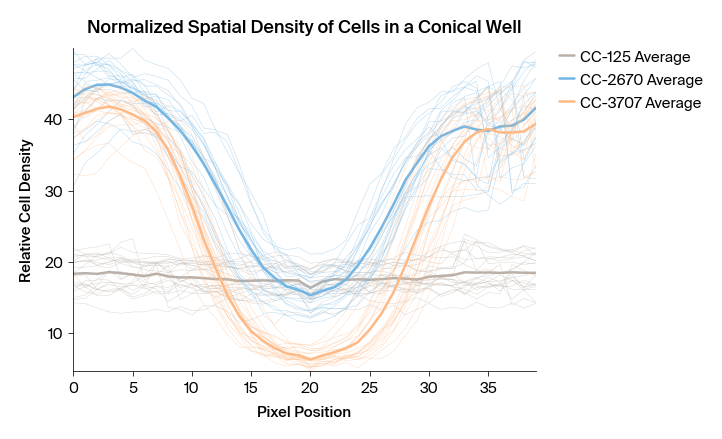

Overlayed plot saved as SVG to: ../results/linescan_strain_results/overlayed_plot_all_strains.svg


In [11]:
# Define color scheme for each strain
strain_color_map = {"CC-125": "#BAB0A8", "CC-2670": "#73B5E3", "CC-3707": "#FFB984"}

# Find the global min and max for y-axis across scans
y_min = min([min(scan) for scan in line_scans])
y_max = max([max(scan) for scan in line_scans])

# Create plot with all 3 strain measurements overlaid
fig, ax = plt.subplots(figsize=(10, 6))

for strain in ["CC-125", "CC-2670", "CC-3707"]:
    # Filter the scans that match the current strain
    strain_scans = [line_scans[i] for i in range(len(line_scans)) if flat_labels[i] == strain]

    # Plot the individual scans
    for scan in strain_scans:
        ax.plot(scan, color=strain_color_map[strain], linewidth=0.5, alpha=0.5)

    # Plot the average scans for the strain
    if strain_scans:
        avg_scan = np.mean(strain_scans, axis=0)
        ax.plot(avg_scan, color=strain_color_map[strain], linewidth=2.5, label=f"{strain} Average")

# Set consistent limits for the x & y axes
ax.set_xlim(0, scan_length - 1)
ax.set_ylim(y_min, y_max)

ax.set_title("Normalized Spatial Density of Cells in a Conical Well", fontstyle="normal")
ax.set_xlabel("Pixel Position")
ax.set_ylabel("Relative Cell Density")
ax.legend(bbox_to_anchor=(1.05, 1), loc="upper left", borderaxespad=0.0)

plt.tight_layout()

# Save the plot as an SVG file
overlayed_plot_path = "../results/linescan_strain_results/overlayed_plot_all_strains.svg"
plt.savefig(overlayed_plot_path, format="svg")
plt.show()

print(f"Overlayed plot saved as SVG to: {overlayed_plot_path}")

---

## Data Analysis - Intensity line scan (Figure 4)
Prior to this analysis, I opened the last single-frame AVI acquired in the dataset in FIJI and cropped the image to only include the wells of interest. I then saved the image as a TIF. 
### Purpose:
This code performs line scan analyses on an image of a 96-well plate seeded with *Chlamydomonas* strains under various treatments to measure cell density and motility defects.

### Key Steps:
1. **Image Handling**

2. **Visualization**

3. **Data Processing**

4. **Plotting**

5. **Statistical Analysis**


### Outputs:
- **Marked Images**: PNG files with visualized line scans and well labels.
- **Line Scan Plots**: SVG files showing the overlayed line scans for each strain and treatment.
- **Data Files**: CSVs with line scan intensities, minimum intensity points, and statistical results.

### Libraries:
- `numpy`, `cv2`, `PIL`, `matplotlib`, `pandas`, `scipy.stats`, `tifffile`, `arcadia_pycolor`, `statsmodels`.

This script automates image analysis, statistical testing, and visualization for line scans in a 96-well plate of *Chlamydomonas* strains treated with various compounds.


## Image Handling

- Loads and verifies a TIFF image, converting it to grayscale if needed.
- Calculates well center positions and generates labels for each well in a 6x12 grid.

In [12]:
# Filepath to the TIFF file
image_path = "../data/vbottom_motility_assay/cropped_final_frames/algae_growth_curve_00000_1724619978-Crop.tif"  # noqa: E501

# Verify that the file exists
if not os.path.exists(image_path):
    print(f"Error: File not found at path {image_path}")
    sys.exit()

# Attempt to open the image using tifffile
try:
    image = tiff.imread(image_path)
    print("Image opened successfully!")
except OSError:
    print("Error: Could not open image with tifffile.")
    sys.exit()

# Convert the image to grayscale
if len(image.shape) > 2:
    image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

# Define the number of rows and columns in the plate
num_rows = 6
num_cols = 12

# Diameter and scan width of the wells
well_diameter = 70
scan_width = 10
scan_length = 40

# Identify the centers of the wells
height, width = image.shape
row_spacing = height // num_rows
col_spacing = width // num_cols

# Calculate precise center positions of the wells
well_centers = [
    (int((row + 0.5) * row_spacing), int((col + 0.5) * col_spacing))
    for row in range(num_rows)
    for col in range(num_cols)
]

# Create a list of well labels
well_labels = [f"Well {row+1}-{col+1}" for row in range(num_rows) for col in range(num_cols)]

Image opened successfully!


## Visualization
- Draws line scans and labels wells with strain and treatment information.
- Saves and displays the modified images with line scans and labels.

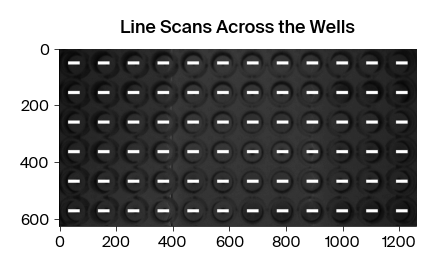

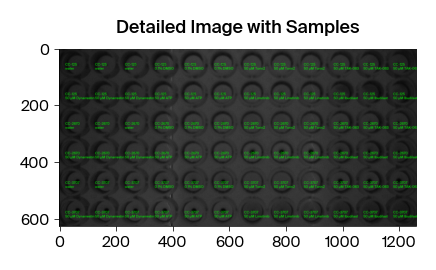

In [13]:
# Create copies of the image for both labeling and line scans
image_with_lines = image.copy()
image_with_details = cv2.cvtColor(image.copy(), cv2.COLOR_GRAY2BGR)

# Indicate labels for each well (strain and treatment)
labels = [
    ["CC-125\nwater", "CC-125\nwater", "CC-125\nwater", "CC-125\n0.1% DMSO", "CC-125\n0.1% DMSO", "CC-125\n0.1% DMSO",
     "CC-125\n50 µM Torin2", "CC-125\n50 µM Torin2", "CC-125\n50 µM Torin2", "CC-125\n50 µM TAK-063", "CC-125\n50 µM TAK-063", "CC-125\n50 µM TAK-063"],
    ["CC-125\n50 µM Dynarrestin", "CC-125\n50 µM Dynarrestin", "CC-125\n50 µM Dynarrestin", "CC-125\n50 µM ATP", "CC-125\n50 µM ATP", "CC-125\n50 µM ATP",
     "CC-125\n50 µM Linsitinib", "CC-125\n50 µM Linsitinib", "CC-125\n50 µM Linsitinib", "CC-125\n50 µM Ibudilast", "CC-125\n50 µM Ibudilast", "CC-125\n50 µM Ibudilast"],
    ["CC-2670\nwater", "CC-2670\nwater", "CC-2670\nwater", "CC-2670\n0.1% DMSO", "CC-2670\n0.1% DMSO", "CC-2670\n0.1% DMSO",
     "CC-2670\n50 µM Torin2", "CC-2670\n50 µM Torin2", "CC-2670\n50 µM Torin2", "CC-2670\n50 µM TAK-063", "CC-2670\n50 µM TAK-063", "CC-2670\n50 µM TAK-063"],
    ["CC-2670\n50 µM Dynarrestin", "CC-2670\n50 µM Dynarrestin", "CC-2670\n50 µM Dynarrestin", "CC-2670\n50 µM ATP", "CC-2670\n50 µM ATP", "CC-2670\n50 µM ATP",
     "CC-2670\n50 µM Linsitinib", "CC-2670\n50 µM Linsitinib", "CC-2670\n50 µM Linsitinib", "CC-2670\n50 µM Ibudilast", "CC-2670\n50 µM Ibudilast", "CC-2670\n50 µM Ibudilast"],
    ["CC-3707\nwater", "CC-3707\nwater", "CC-3707\nwater", "CC-3707\n0.1% DMSO", "CC-3707\n0.1% DMSO", "CC-3707\n0.1% DMSO",
     "CC-3707\n50 µM Torin2", "CC-3707\n50 µM Torin2", "CC-3707\n50 µM Torin2", "CC-3707\n50 µM TAK-063", "CC-3707\n50 µM TAK-063", "CC-3707\n50 µM TAK-063"],
    ["CC-3707\n50 µM Dynarrestin", "CC-3707\n50 µM Dynarrestin", "CC-3707\n50 µM Dynarrestin", "CC-3707\n50 µM ATP", "CC-3707\n50 µM ATP", "CC-3707\n50 µM ATP",
     "CC-3707\n50 µM Linsitinib", "CC-3707\n50 µM Linsitinib", "CC-3707\n50 µM Linsitinib", "CC-3707\n50 µM Ibudilast", "CC-3707\n50 µM Ibudilast", "CC-3707\n50 µM Ibudilast"]
]

# Flatten the labels for easier indexing
flat_labels = [label for row in labels for label in row]

# Load the Suisse Int'l font
try:
    font_path = "/path/to/SuisseIntl-Regular.ttf"
    font = ImageFont.truetype(font_path, 12)
except OSError:
    print("Suisse Int'l font not found. Using default font.")
    font = ImageFont.load_default()

# Convert the image_with_details to PIL format for text drawing
image_with_details_pil = Image.fromarray(cv2.cvtColor(image_with_details, cv2.COLOR_BGR2RGB))
draw = ImageDraw.Draw(image_with_details_pil)

# Perform line scans and draw the scans and labels on the images
for i, (center_y, center_x) in enumerate(well_centers):
    # Calculate the start and end points of the scan line
    start_x = max(center_x - scan_length // 2, 0)
    end_x = min(center_x + scan_length // 2, width - 1)

    # Perform a horizontal line scan across the center with a width of scan_width
    for offset in range(-scan_width // 2, scan_width // 2 + 1):
        rr, cc = line(center_y + offset, start_x, center_y + offset, end_x)
        image_with_lines[rr, cc] = 255  # Mark the line in white

    # Add sample details to the detailed image using PIL
    draw.text((center_x - 30, center_y), flat_labels[i], font=font, fill=(0, 255, 0))

# Convert the labeled image back to OpenCV format
image_with_details = cv2.cvtColor(np.array(image_with_details_pil), cv2.COLOR_RGB2BGR)

# Save the images
output_dir = "../results/linescan_drug_results"
os.makedirs(output_dir, exist_ok=True)

marked_image_path = os.path.join(output_dir, "marked_well_lines.png")
details_image_path = os.path.join(output_dir, "marked_details.png")
cv2.imwrite(marked_image_path, image_with_lines)
cv2.imwrite(details_image_path, image_with_details)

# Display the images
plt.imshow(image_with_lines, cmap="gray")
plt.title("Line Scans Across the Wells")
plt.show()

plt.imshow(image_with_details)
plt.title("Detailed Image with Samples")
plt.show()

## Data Processing
- Performs horizontal line scans for each well, realigns based on minimum intensity.
- Calculates and stores metrics: average intensity, minimum intensity, difference, and fraction.

In [14]:
# Perform line scans, calculate metrics (minimum intensity, difference, and fraction)
line_scans = []
min_intensity_points = []
diff_avg_min = []
frac_avg_min = []

for i, (center_y, center_x) in enumerate(well_centers):
    # Calculate the start and end points of the scan line
    start_x = max(center_x - scan_length // 2, 0)
    end_x = min(center_x + scan_length // 2, width - 1)

    # Perform a horizontal line scan across the center with a width of scan_width
    line_intensity = []
    for offset in range(-scan_width // 2, scan_width // 2 + 1):
        rr, cc = line(center_y + offset, start_x, center_y + offset, end_x)
        line_intensity.append(image[rr, cc])

    # Ensure all scans are of the same length by trimming to scan_length
    line_intensity = [scan[:scan_length] for scan in line_intensity]
    line_intensity = np.mean(line_intensity, axis=0)

    # Realign the line scan by aligning the minimum point within a broader search region
    broader_search_indices = np.arange(10, 30)  # Adjusted for new scan length
    min_index = broader_search_indices[np.argmin(line_intensity[broader_search_indices])]
    shift = (scan_length // 2) - min_index  # Align the minimum point to the center
    line_intensity = np.roll(line_intensity, shift)

    # Store the realigned and normalized result
    line_scans.append(line_intensity)

    # Calculate the metrics:
    avg_33_37 = np.mean(line_intensity[33:38])  # Average between pixels 33-37
    min_intensity = np.min(line_intensity)  # Minimum intensity point
    diff_avg_min.append(avg_33_37 - min_intensity)  # Difference between avg (33-37) and min
    frac_avg_min.append(
        avg_33_37 / min_intensity if min_intensity != 0 else np.nan
    )  # Fraction of avg over min

    # Store the minimum intensity point with its strain and treatment
    min_intensity_points.append(
        {
            "Well": well_labels[i],
            "Strain": flat_labels[i].split("\n")[0],
            "Treatment": flat_labels[i].split("\n")[1],
            "Min_Intensity": min_intensity,
        }
    )

## Plotting
- Plots individual and average line scans for each strain and treatment.
- Saves each strain's plot as an SVG file and displays the result.

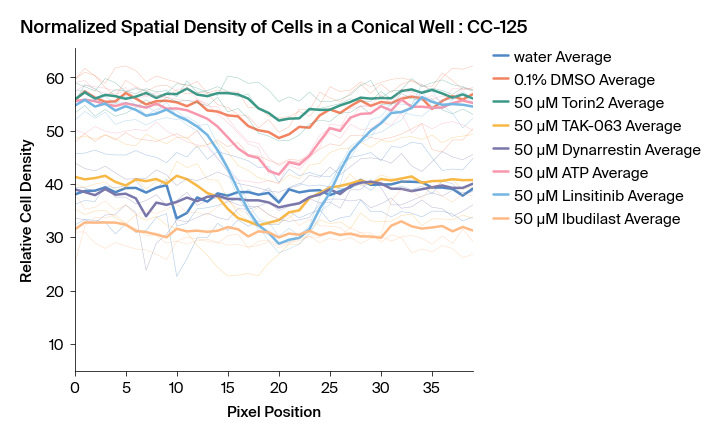

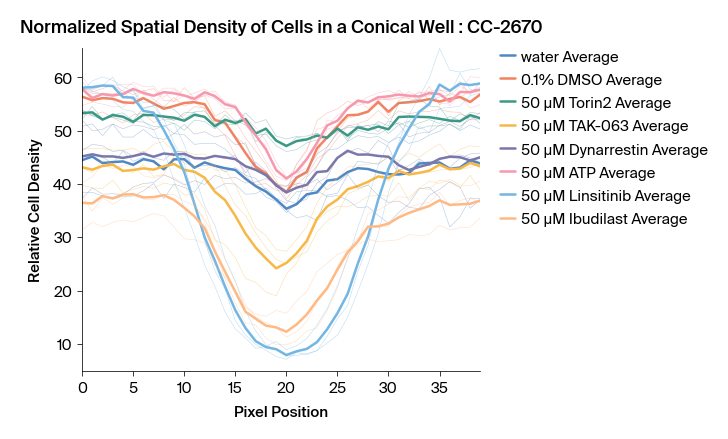

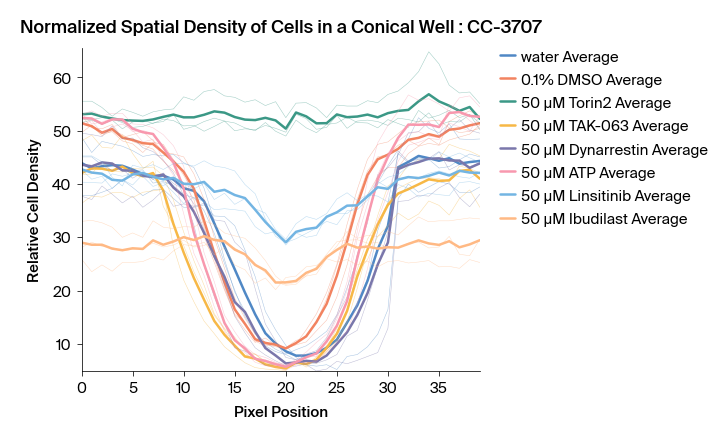

In [15]:
# Define the color scheme for treatments
treatment_color_map = {
    "water": "#5088C5",
    "0.1% DMSO": "#F28360",
    "50 µM Torin2": "#3B9886",
    "50 µM TAK-063": "#F7B846",
    "50 µM Dynarrestin": "#7A77AB",
    "50 µM ATP": "#F898AE",
    "50 µM Linsitinib": "#73B5E3",
    "50 µM Ibudilast": "#FFB984",
}

# Find the global minimum and maximum for y-axis across all scans
y_min = min([min(scan) for scan in line_scans])
y_max = max([max(scan) for scan in line_scans])

# Create separate plots for each strain with different treatments
for strain in ["CC-125", "CC-2670", "CC-3707"]:
    fig, ax = plt.subplots(figsize=(10, 6))

    # Plot individual scans and averages for each treatment in the current strain
    for treatment in treatment_color_map.keys():
        # Filter the scans that match the current strain and treatment
        treatment_scans = [
            line_scans[i]
            for i in range(len(line_scans))
            if flat_labels[i].split("\n")[0] == strain
            and flat_labels[i].split("\n")[1] == treatment
        ]

        # Plot the individual scans
        for scan in treatment_scans:
            ax.plot(scan, color=treatment_color_map[treatment], linewidth=0.5, alpha=0.5)

        # Plot the average scan
        if treatment_scans:
            avg_scan = np.mean(treatment_scans, axis=0)
            ax.plot(
                avg_scan,
                color=treatment_color_map[treatment],
                linewidth=2.5,
                label=f"{treatment} Average",
            )

    # Set consistent limits for x and y axes
    ax.set_xlim(0, scan_length - 1)
    ax.set_ylim(y_min, y_max)

    ax.set_title(
        f"Normalized Spatial Density of Cells in a Conical Well : {strain}", fontstyle="normal"
    )
    ax.set_xlabel("Pixel Position")
    ax.set_ylabel("Relative Cell Density")

    # Place the legend outside of the plot
    ax.legend(bbox_to_anchor=(1.05, 1), loc="upper left", borderaxespad=0.0)

    plt.tight_layout()

    # Save the plot as an SVG file
    overlayed_plot_path = os.path.join(output_dir, f"overlayed_plot_{strain}.svg")
    plt.savefig(overlayed_plot_path, format="svg")

    plt.show()

## Statistical Analysis
- Exports minimum intensity data and associated metrics (difference, fraction) to a CSV file.
- Performs ANOVA and Tukey’s HSD for statistical analysis on each strain and metric, saving the results to a CSV file.

In [16]:
# Export minimum intensity points as a CSV file
min_intensity_df = pd.DataFrame(min_intensity_points)
min_intensity_df["Diff_Avg_Min"] = diff_avg_min
min_intensity_df["Frac_Avg_Min"] = frac_avg_min

min_intensity_csv_path = os.path.join(output_dir, "min_intensity_points.csv")
min_intensity_df.to_csv(min_intensity_csv_path, index=False)

print(f"Minimum intensity points saved to: {min_intensity_csv_path}")

# Initialize a list to store the statistical results
stats_results = []

# Independent Statistical Analysis for Each Strain and Metric
for strain in ["CC-125", "CC-2670", "CC-3707"]:
    print(f"\n--- Statistical Analysis for {strain} ---")
    strain_data = min_intensity_df[min_intensity_df["Strain"] == strain]

    # Descriptive statistics for each metric
    desc_stats = strain_data.groupby("Treatment").describe()
    print(desc_stats)

    # Loop over the three metrics (Min_Intensity, Diff_Avg_Min, Frac_Avg_Min)
    for metric in ["Min_Intensity", "Diff_Avg_Min", "Frac_Avg_Min"]:
        print(f"\n--- ANOVA and Tukey for {metric} ---")

        # One-way ANOVA
        anova_result = stats.f_oneway(
            *[
                strain_data[strain_data["Treatment"] == treatment][metric]
                for treatment in strain_data["Treatment"].unique()
            ]
        )
        print(
            f"ANOVA result for {metric} in {strain}: F={anova_result.statistic}, "
            f"p={anova_result.pvalue}"
        )

        # If ANOVA is significant, perform post-hoc testing with Tukey's HSD
        if anova_result.pvalue < 0.05:
            tukey_result = pairwise_tukeyhsd(
                strain_data[metric], strain_data["Treatment"], alpha=0.05
            )
            print(tukey_result)
            # Append Tukey results to the stats_results list
            tukey_df = pd.DataFrame(
                data=tukey_result.summary().data[1:], columns=tukey_result.summary().data[0]
            )
            tukey_df["Strain"] = strain
            tukey_df["Metric"] = metric
            stats_results.append(tukey_df)

# Combine all the statistical results into a single DataFrame
if stats_results:
    final_stats_df = pd.concat(stats_results, ignore_index=True)
    stats_csv_path = os.path.join(output_dir, "statistical_results.csv")
    final_stats_df.to_csv(stats_csv_path, index=False)
    print(f"Statistical results saved to: {stats_csv_path}")

Minimum intensity points saved to: ../results/linescan_drug_results/min_intensity_points.csv

--- Statistical Analysis for CC-125 ---
                  Min_Intensity                                             \
                          count       mean       std        min        25%   
Treatment                                                                    
0.1% DMSO                   3.0  48.636364  4.464738  43.727273  46.727273   
50 µM ATP                   3.0  41.787879  1.682023  40.090909  40.954545   
50 µM Dynarrestin           3.0  31.757576  7.396857  23.818182  28.409091   
50 µM Ibudilast             3.0  26.848485  2.611692  24.909091  25.363636   
50 µM Linsitinib            3.0  28.787879  1.567578  27.090909  28.090909   
50 µM TAK-063               3.0  31.757576  8.743041  22.727273  27.545455   
50 µM Torin2                3.0  51.909091  3.689386  48.090909  50.136364   
water                       3.0  31.666667  8.825832  22.636364  27.363636   

       